# 2022年7月5日12:25:57

# 使用2次插值函数作为形函数

In [3]:
import numpy as np
from numpy.polynomial.legendre import leggauss
import matplotlib.pyplot as plt

# 1. 问题描述

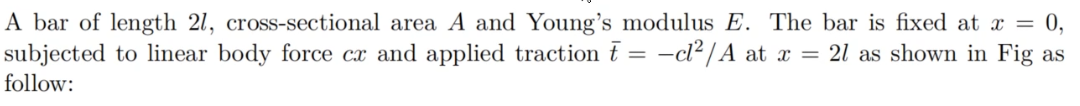
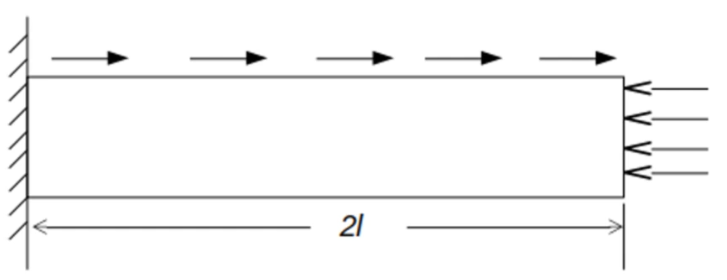

# 2. 物理模型-强形式

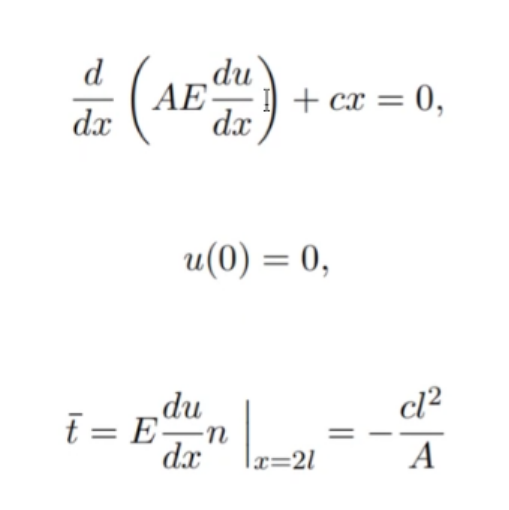


该问题有解析解：
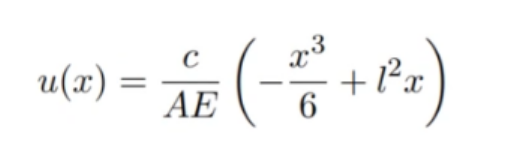

# 3. 转化为弱形式

在方程两边同时乘以试函数$w$，并进行积分：
$$\int_{2l}w\frac{d}{dx}(AE\frac{du}{dx})dx+\int_{2l}wcxdx=0$$
  
    
对第一项应用分部积分法，可得：
$$wAE\frac{du}{dx}|^{2l}_{x=0}-\int_{2l}\frac{dw}{dx}AE\frac{du}{dx}dx+\int_{2l}wcxdx=0$$
  
    
将边界条件带入可得：[因为$u(x=0)=0$是常数，所以在$x=0$处，$\frac{du}{dx}=0$]

  
$$-wcl^2-0-\int_{2l}\frac{dw}{dx}AE\frac{du}{dx}dx+\int_{2l}wcxdx=0$$

  
调整位置后为：
$$\int_{2l}\frac{dw}{dx}AE\frac{du}{dx}dx=\int_{2l}wcxdx-wcl^2|_{x=2l}$$

  
Neumman边界条件已经自动地带入到控制方程的弱形式中了，但Dirichlet边界条件加不进去（个人认为是因为没有跟$w$关联起来），整个弱形式为：
  
$$\int_{2l}\frac{dw}{dx}AE\frac{du}{dx}dx=\int_{2l}wcxdx-wcl^2|_{x=2l}$$

$$u(x=0)=0$$

# 4. 转化为矩阵--一个单元内

In [2]:
# 定义变量
E=10e4
A=1
c=1
l=1

In [228]:
# 定义单元
n_e=20            # 单元个数 number of elements
n_n=2*n_e+1        # 节点个数 number of nodes
x_n=np.linspace(0,2*l,n_n)    # 节点坐标 x of node

In [229]:
# 定义形函数
# fl function of left
def fl(x,xl,xr):
    xm=(xl+xr)/2
    return (x-xm)*(x-xr)/((xl-xm)*(xl-xr))

# fm funciton of midle
def fm(x,xl,xr):
    xm=(xl+xr)/2
    return (x-xl)*(x-xr)/((xm-xl)*(xm-xr))

# fr function of right
def fr(x,xl,xr):
    xm=(xl+xr)/2
    return (x-xl)*(x-xm)/((xr-xl)*(xr-xm))

In [230]:
plt.style.use(['science','grid','notebook'])

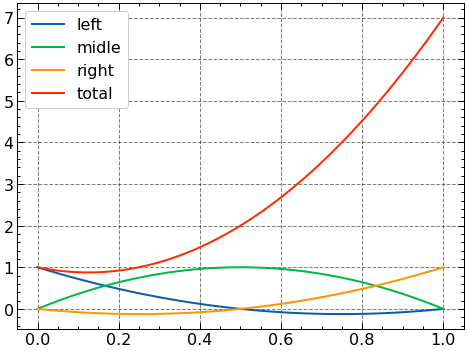

In [231]:
# 测试
# 测试点[0,1],[0.5,2],[1,7]
x=np.linspace(0,1)
plt.plot(x,fl(x,0,1),label='left')
plt.plot(x,fm(x,0,1),label='midle')
plt.plot(x,fr(x,0,1),label='right')
plt.plot(x,fl(x,0,1)+2*fm(x,0,1)+7*fr(x,0,1),label='total')
plt.legend()
plt.show()

In [232]:
# 定义形函数导数
def dfl(x,xl,xr):
    xm=(xl+xr)/2
    return ((x-xr)+(x-xm))/((xl-xm)*(xl-xr))

def dfm(x,xl,xr):
    xm=(xl+xr)/2
    return ((x-xr)+(x-xl))/((xm-xl)*(xm-xr))

def dfr(x,xl,xr):
    xm=(xl+xr)/2
    return ((x-xm)+(x-xl))/((xr-xl)*(xr-xm))
                        

In [233]:
#  定义数值积分函数，使用勒让德-高斯积分
# n 为取样点数；a,b分别为积分下限和上限
def leg_gau_quad(f,n,a,b):
    x,w=leggauss(n)    # 返回取样坐标和权重
    summ=0
    for i in range(len(x)):
        summ+=w[i]*f((a+b)/2+(b-a)/2*x[i])
    return (b-a)/2*summ

In [234]:
# 测试
a=0
b=0.2
f=lambda x:dfl(x,a,b)*dfl(x,a,b)
print(leg_gau_quad(f,3,a,b))

a=10
b=10.2
f=lambda x:dfl(x,a,b)*dfl(x,a,b)
print(leg_gau_quad(f,3,a,b))

11.666666666666668
11.666666666666558


此时$K_{ei}$矩阵为$3\times3$，同样计算顶一个单元格内的$K$矩阵作为$K_e$

In [235]:
x0=x_n[0]
x1=x_n[2]
df=[dfl,dfm,dfr]
Ke=np.zeros((3,3))
for i in range(3):
    for j in range(3):
        dff=lambda x:A*E*df[i](x,x0,x1)*df[j](x,x0,x1)
        Ke[i,j]=leg_gau_quad(dff,3,x0,x1)
    
Ke

array([[ 2333333.33333333, -2666666.66666667,   333333.33333333],
       [-2666666.66666667,  5333333.33333334, -2666666.66666667],
       [  333333.33333333, -2666666.66666667,  2333333.33333333]])

# 5. 组装矩阵

其要点是在单元格边界处的格点是两个单元格所共用的，即应相加起来

In [236]:
# 组装K矩阵
K=np.zeros((n_n,n_n))
for i in range(n_e):
    K[2*i:2*i+3,2*i:2*i+3]+=Ke


In [237]:
# 组装F矩阵
F=np.zeros(n_n)
Fe=np.zeros(3)
for i in range(n_e):
    Fl=lambda x:fl(x,x_n[2*i],x_n[2*(i+1)])*c*x
    Fe[0]=leg_gau_quad(Fl,3,x_n[2*i],x_n[2*(i+1)])
    Fm=lambda x:fm(x,x_n[2*i],x_n[2*(i+1)])*c*x
    Fe[1]=leg_gau_quad(Fm,3,x_n[2*i],x_n[2*(i+1)])
    Fr=lambda x:fr(x,x_n[2*i],x_n[2*(i+1)])*c*x
    Fe[2]=leg_gau_quad(Fr,3,x_n[2*i],x_n[2*(i+1)])
    F[2*i:2*i+3]+=Fe

In [238]:
F[-1]

0.03333333333333323

## 组装矩阵F 添加Neumman边界条件


In [239]:
# 边界条件--Neumman
F[-1]-=c*l**2
F[-1]

-0.9666666666666668

## 组装矩阵F 添加Dirichlet条件

In [240]:
# 边界条件--Dirichlet
F[0]=0
K[0,:]=0
K[:,0]=0
K[0,0]=1

# 6. 求解

In [241]:
U=np.zeros(n_n)
U[:]=np.linalg.solve(K,F)

In [203]:
# 解析解 f of exact
fex=lambda x:c/(A*E)*(-x**3/6+l**2*x)

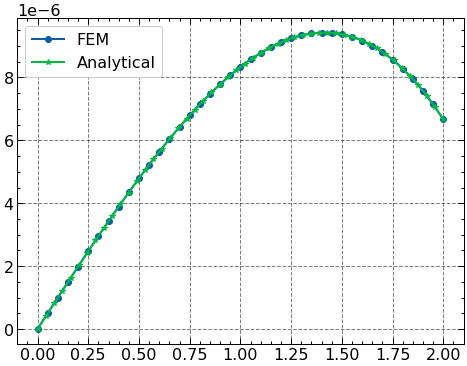

In [204]:
plt.plot(x_n,U,'-o',label='FEM')
xn=np.linspace(0,2)
plt.plot(xn,fex(xn),'-*',label='Analytical')
plt.legend()
plt.show()

# 7. 收敛性分析

In [205]:
from scipy import integrate

In [206]:
err_12=0

fs=[fl,fm,fr]  # function of shape
for i in range(n_e):
    uFEM=lambda x: sum(fs[j](x,x_n[2*i],x_n[2*(i+1)])*U[2*i+j] for j in range(len(fs)))
    ferror=lambda x:(fex(x)-uFEM(x))**2
    err_12_element=leg_gau_quad(ferror,20,x_n[2*i],x_n[2*(i+1)])
    err_12+=err_12_element
    
u_ex_s=integrate.quad(fex,0,2)[0]  
err_norm=np.sqrt(err_12/u_ex_s)

In [207]:
err_norm

2.2271770159306475e-08

# 8. 把函数集合起来

In [213]:

def buildE(n):
    n_e=n   # 单元个数 number of elements
    n_n=2*n_e+1 # 节点个数 number of node
    x_n=np.linspace(0,2*l,n_n) # 节点坐标 x of node
    return (n_e,n_n,x_n)

def buildK(n):
    n_e,n_n,x_n=buildE(n)
    x0=x_n[0]
    x1=x_n[2]
    df=[dfl,dfm,dfr]
    Ke=np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            dff=lambda x:A*E*df[i](x,x0,x1)*df[j](x,x0,x1)
            Ke[i,j]=leg_gau_quad(dff,3,x0,x1)

    # 组装K矩阵
    K=np.zeros((n_n,n_n))
    for i in range(n_e):
        K[2*i:2*i+3,2*i:2*i+3]+=Ke

    return K

def buildFK(n):
    n_e,n_n,x_n=buildE(n)
    K=buildK(n)
    F=np.zeros(n_n)
    Fe=np.zeros(3)
    for i in range(n_e):
        Fl=lambda x:fl(x,x_n[2*i],x_n[2*(i+1)])*c*x
        Fe[0]=leg_gau_quad(Fl,3,x_n[2*i],x_n[2*(i+1)])
        Fm=lambda x:fm(x,x_n[2*i],x_n[2*(i+1)])*c*x
        Fe[1]=leg_gau_quad(Fm,3,x_n[2*i],x_n[2*(i+1)])
        Fr=lambda x:fr(x,x_n[2*i],x_n[2*(i+1)])*c*x
        Fe[2]=leg_gau_quad(Fr,3,x_n[2*i],x_n[2*(i+1)])
        F[2*i:2*i+3]+=Fe

    # 边界条件--Neumman
    F[-1]-=c*l**2

    # 边界条件--Dirichlet
    F[0]=0
    K[0,:]=0
    K[:,0]=0
    K[0,0]=1
    
    return F,K

def solve(n):
    n_e,n_n,x_n=buildE(n)
    F,K=buildFK(n)
    U=np.zeros(n_n)
    U[:]=np.linalg.solve(K,F)
    
    return U

def analyze(n):
    n_e,n_n,x_n=buildE(n)
    U=solve(n)
    err_12=0
    fs=[fl,fm,fr]  # function of shape
    for i in range(n_e):
        uFEM=lambda x: sum(fs[j](x,x_n[2*i],x_n[2*(i+1)])*U[2*i+j] for j in range(len(fs)))
        ferror=lambda x:(fex(x)-uFEM(x))**2
        err_12_element=leg_gau_quad(ferror,20,x_n[2*i],x_n[2*(i+1)])
        err_12+=err_12_element

    u_ex_s=integrate.quad(fex,0,2)[0]  
    err_norm=np.sqrt(err_12/u_ex_s)
    
    return err_norm

## 8.1 不同的单元个数对结果的影响

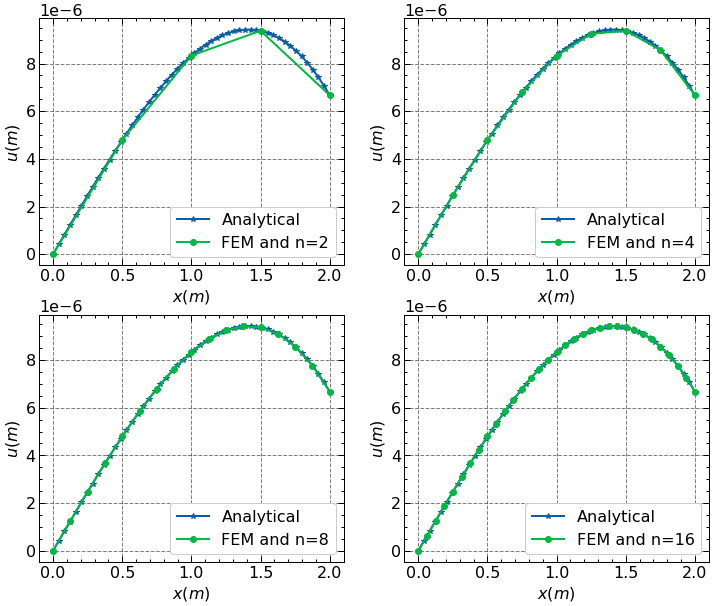

In [243]:
n=[2,4,8,16]
x_n=[buildE(i)[-1] for i in n]
U=[solve(i) for i in n]
x=np.linspace(0,2)

fig,axes=plt.subplots(2,2,figsize=(12,10))
for i in range(2):
    for j in range(2):
        ax=axes[i][j]
        ax.plot(x,fex(x),'-*',label='Analytical')
        ax.plot(x_n[2*i+j],U[2*i+j],'-o',label=f'FEM and n={n[2*i+j]}')
        ax.set_xlabel('$x (m)$')
        ax.set_ylabel('$u (m)$')
        ax.legend()

## 8.2 不同的单元个数对相对误差的影响

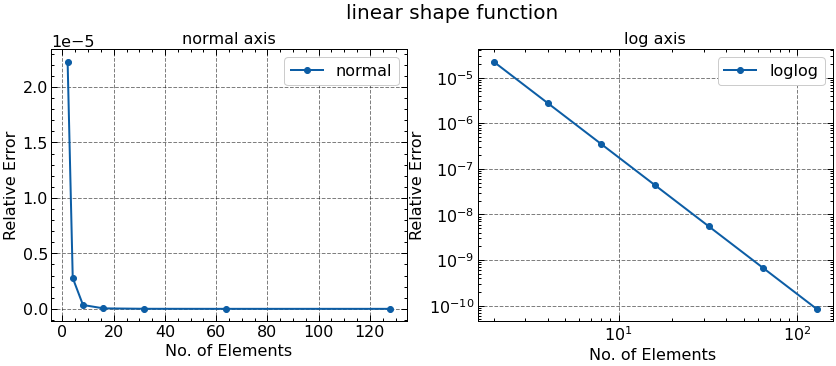

In [225]:
n=[2,4,8,16,32,64,128]
error=[analyze(i) for i in n]
fig,axes=plt.subplots(1,2,figsize=(14,5))

ax=axes[0]
ax.plot(n,error,'-o',label='normal')
ax.set_xlabel('No. of Elements')
ax.set_ylabel('Relative Error')
ax.set_title('normal axis')
ax.legend()

ax=axes[1]
ax.plot(n,error,'-o',label='loglog')
ax.set_xlabel('No. of Elements ')
ax.set_ylabel('Relative Error')
ax.set_title('log axis')
ax.loglog()
ax.legend()
plt.text(0.3,20e-5,'linear shape function',fontsize=20)
plt.show()